In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.cross_decomposition import CCA
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm

In [ ]:
# Gaussian kernel for weighting distances
def gaussian_kernel(d, r):
    """
    Gaussian kernel function.
    :param d: Array of distances.
    :param r: Bandwidth (set as the distance to the k-th neighbor).
    :return: Array of weights.
    """
    return np.exp(-(d / r) ** 2)

# bisquare kernel for weighting distances
def bisquare_kernel(d, r):
    """
    Bisquare kernel function.
    :param d: Distance vector.
    :param r: Local bandwidth.
    :return: Weight vector.
    """
    w = np.zeros_like(d)
    mask = d <= r
    w[mask] = (1 - (d[mask] / r) ** 2) ** 2
    return w

def gw_covariance(X, Y, W):
    """
    Calculate weighted covariance matrices after removing the weighted mean.
    :param X: First variable set (n x p).
    :param Y: Second variable set (n x q).
    :param W: Weight vector (n,).
    :return: Sigma_XX, Sigma_YY, Sigma_XY.
    """
    W = W.reshape(-1,1)
    sumW = W.sum()
    mu_X = (W*X).sum(axis=0)/sumW
    mu_Y = (W*Y).sum(axis=0)/sumW
    Xc   = X - mu_X
    Yc   = Y - mu_Y
    Sigma_XX = (Xc*W).T @ Xc / sumW
    Sigma_YY = (Yc*W).T @ Yc / sumW
    Sigma_XY = (Xc*W).T @ Yc / sumW
    return Sigma_XX, Sigma_YY, Sigma_XY

def gwcca_local(X, Y, coords, k_neighbors, q=2):
    """
    Compute local canonical correlations and loadings using GWCCA.
    :param X: (n x p) data array for set X.
    :param Y: (n x q) data array for set Y.
    :param coords: (n x 2) coordinate array.
    :param k_neighbors: Number of nearest neighbors for local estimation.
    :param q: Number of canonical variables to retain.
    :return: rho (canonical correlations), a (loadings for X), b (loadings for Y).
    """
    n, p  = X.shape
    q_Y    = Y.shape[1]
    r = q

    rho = np.zeros((n, r))
    a = np.zeros((n, p, r))
    b = np.zeros((n, q_Y, r))

    tree = cKDTree(coords)

    for i in range(n):
        # Get k+1 neighbors (including the point itself)
        d, idx = tree.query(coords[i], k=k_neighbors + 1)
        # Set local bandwidth as the distance to the k-th neighbor
        bandwidth = d[-1]
        # Compute weights with Gaussian kernel (or replace with bisquare_kernel if desired)
        W = gaussian_kernel(d, bandwidth)

        # Compute weighted covariance matrices using only neighbors (with local mean removal)
        Sigma_XX, Sigma_YY, Sigma_XY = gw_covariance(X[idx], Y[idx], W)

        # Regularize to ensure numerical stability
        Sigma_XX += np.eye(p)
        Sigma_YY += np.eye(q_Y)

        try:
            inv_Sigma_XX = np.linalg.pinv(Sigma_XX)
            inv_Sigma_YY = np.linalg.pinv(Sigma_YY)
            M = inv_Sigma_XX @ Sigma_XY @ inv_Sigma_YY @ Sigma_XY.T
            eigenvalues, eigenvectors = np.linalg.eig(M)

            sorted_indices = np.argsort(eigenvalues)[::-1]
            top_q_indices = sorted_indices[:q]

            rho[i] = np.sqrt(eigenvalues[top_q_indices])
            a[i] = eigenvectors[:, top_q_indices]
            b[i] = inv_Sigma_YY @ Sigma_XY.T @ a[i]

        except np.linalg.LinAlgError:
            rho[i] = np.nan
            a[i] = np.nan
            b[i] = np.nan

        sign_vec = np.sign(a[i, 0, :])
        sign_vec[sign_vec == 0] = 1
        a[i] *= sign_vec
        b[i] *= sign_vec

    return rho, a, b


def _huber_weights(u, delta):
    # u = |residual| / scale  (nonnegative)
    # Huber weight = psi(u)/u with psi(u)=min(u, delta)
    w = np.ones_like(u)
    m = u > 0
    w[m] = np.minimum(u[m], delta) / (u[m] + 1e-15)
    return w


def robust_cov_block(X, Y, W_base, delta=1.345, max_iter=10, tol=1e-4):
    """
    Robustify the local covariance using Huber M-estimation (IRLS) on the
    concatenated vector Z=[X,Y]. Returns Sxx, Syy, Sxy with final weights applied.
    - X: (m,p), Y: (m,q), W_base: (m,1) spatial kernel weights (>=0)
    """
    m, p = X.shape
    q = Y.shape[1]
    Z = np.hstack([X, Y])                # (m, p+q)
    W = W_base.reshape(-1, 1).astype(float)
    W = W / (W.sum() + 1e-15)

    # init location: spatially-weighted mean
    mu = (W * Z).sum(axis=0, keepdims=True)

    # scale for joint residual norm: MAD of norms (robust)
    r = np.linalg.norm(Z - mu, axis=1)
    med = np.median(r)
    mad = np.median(np.abs(r - med)) + 1e-12
    s = 1.4826 * mad if mad > 0 else (r.mean() + 1e-12)

    for _ in range(max_iter):
        r = np.linalg.norm(Z - mu, axis=1)          # residual norms
        u = r / (s + 1e-12)
        w_h = _huber_weights(u, delta).reshape(-1, 1)
        W_eff = W * w_h                               # spatial × robust

        mu_new = (W_eff * Z).sum(axis=0, keepdims=True) / (W_eff.sum() + 1e-15)
        shift = np.linalg.norm(mu_new - mu)
        mu = mu_new

        # re-estimate scale from weighted residuals (Huber proposal 2 style)
        r = np.linalg.norm(Z - mu, axis=1)
        s = np.sqrt(np.sum((W_eff.ravel() * np.minimum(r, delta*s)**2)) /
                    (W_eff.sum() + 1e-15)) + 1e-12

        if shift < tol:
            break

    # final effective weights
    r = np.linalg.norm(Z - mu, axis=1)
    u = r / (s + 1e-12)
    w_h = _huber_weights(u, delta).reshape(-1, 1)
    W_eff = W * w_h
    W_eff = W_eff / (W_eff.sum() + 1e-15)

    # split back into X/Y and form covariances
    mu_X = mu[:, :p].ravel()
    mu_Y = mu[:, p:].ravel()
    Xc = X - mu_X
    Yc = Y - mu_Y

    Sxx = (Xc * W_eff).T @ Xc
    Syy = (Yc * W_eff).T @ Yc
    Sxy = (Xc * W_eff).T @ Yc
    return Sxx, Syy, Sxy



def gwcca_local_robust(X, Y, coords, k_neighbors, q=None, include_self=True, return_all=True,
                       delta=1.345, max_iter=10, tol=1e-4,
                       kernel="gaussian", eps_eig=1e-12, ridge=None):
    """
    Robust local GWCCA:
    - Robust covariance by Huber-IRLS on Z=[X,Y]
    - Whitening + SVD
    - Re-normalization so A^T Sxx A = I and B^T Syy B = I
    """
    n, p  = X.shape
    qY    = Y.shape[1]
    r_max = min(p, qY)
    r     = (q if q is not None else (r_max if return_all else 1))
    r     = min(r, r_max)

    rho = np.full((n, r), np.nan, dtype=float)
    a   = np.full((n, p,  r), np.nan, dtype=float)
    b   = np.full((n, qY, r), np.nan, dtype=float)

    tree = cKDTree(coords)

    def _kernel_weights(d, bw):
        if kernel == "bisquare":
            w = np.zeros_like(d)
            m = d <= bw
            w[m] = (1 - (d[m]/bw)**2)**2
            return w
        return np.exp(-(d / bw) ** 2)

    def _huber_weights(u, delta_):
        w = np.ones_like(u)
        m = u > 0
        w[m] = np.minimum(u[m], delta_) / (u[m] + 1e-15)
        return w

    for i in range(n):
        d, idx = tree.query(coords[i], k=k_neighbors + 1)
        if not include_self:
            m = (idx != i)
            d, idx = d[m], idx[m]
        if idx.size < 2:
            continue

        bw = d[-1] if d.size > 0 else 1.0
        w0 = _kernel_weights(d, bw).reshape(-1, 1)
        w0 /= (w0.sum() + 1e-15)

        Xi, Yi = X[idx], Y[idx]
        Z = np.hstack([Xi, Yi])  # (m, p+qY)

        #
        W = w0.copy()
        mu = (W * Z).sum(axis=0, keepdims=True)

        rn = np.linalg.norm(Z - mu, axis=1)
        med = np.median(rn)
        mad = np.median(np.abs(rn - med)) + 1e-12
        s = 1.4826 * mad if mad > 0 else (rn.mean() + 1e-12)

        for _ in range(max_iter):
            rn = np.linalg.norm(Z - mu, axis=1)
            u  = rn / (s + 1e-15)
            wh = _huber_weights(u, delta).reshape(-1, 1)
            W  = (w0 * wh)
            W /= (W.sum() + 1e-15)

            mu_new = (W * Z).sum(axis=0, keepdims=True)
            if np.linalg.norm(mu_new - mu) < tol:
                mu = mu_new
                break
            mu = mu_new

            rn = np.linalg.norm(Z - mu, axis=1)
            s  = np.sqrt(np.sum((W.ravel() * np.minimum(rn, delta * s) ** 2)) /
                         (W.sum() + 1e-15)) + 1e-12


        W /= (W.sum() + 1e-15)

        mu_X = mu[:, :p].ravel()
        mu_Y = mu[:, p:].ravel()
        Xc = Xi - mu_X
        Yc = Yi - mu_Y

        Sxx = (Xc * W).T @ Xc
        Syy = (Yc * W).T @ Yc
        Sxy = (Xc * W).T @ Yc

        if ridge is not None and ridge > 0:
            Sxx = Sxx + float(ridge) * np.eye(p)
            Syy = Syy + float(ridge) * np.eye(qY)

        eval_x, evec_x = np.linalg.eigh(Sxx)
        eval_y, evec_y = np.linalg.eigh(Syy)
        eval_x = np.clip(eval_x, eps_eig, None)
        eval_y = np.clip(eval_y, eps_eig, None)
        Sxx_mh = evec_x @ np.diag(1.0/np.sqrt(eval_x)) @ evec_x.T
        Syy_mh = evec_y @ np.diag(1.0/np.sqrt(eval_y)) @ evec_y.T

        K = Sxx_mh @ Sxy @ Syy_mh

        U, s, Vt = np.linalg.svd(K, full_matrices=False)
        s  = s[:r]
        U  = U[:, :r]
        Vt = Vt[:r, :]

        A = Sxx_mh @ U
        B = Syy_mh @ Vt.T

        for j in range(r):
            aj = A[:, j]
            bj = B[:, j]
            sxa = float(np.sqrt(aj.T @ Sxx @ aj) + 1e-15)
            syb = float(np.sqrt(bj.T @ Syy @ bj) + 1e-15)
            A[:, j] = aj / sxa
            B[:, j] = bj / syb

        signs = np.sign(A[0, :]); signs[signs == 0] = 1.0
        A *= signs; B *= signs

        rho[i, :] = s
        a[i, :, :] = A
        b[i, :, :] = B

    return rho, a, b


# Spatial Smoothing of Loadings using KNN-based Gaussian kernel smoother
def spatial_smooth_loadings(loadings, coords, k_neighbors):
    """
    Smooth spatially varying loadings using a KNN-based Gaussian kernel smoother.
    :param loadings: Array of loadings (n x p x q).
    :param coords: Array of coordinates (n x 2).
    :param k_neighbors: Number of nearest neighbors to use for smoothing.
    :return: Smoothed loadings (n x p x q).
    """
    n, p, q = loadings.shape
    smoothed = np.zeros_like(loadings)
    tree = cKDTree(coords)

    for i in range(n):
        # Use the same k_neighbors for smoothing (including self)
        d, idx = tree.query(coords[i], k=k_neighbors + 1)
        # Set bandwidth as the distance to the k-th neighbor
        bandwidth = d[-1]
        weights = gaussian_kernel(d, bandwidth)
        weights = weights / weights.sum()
        smoothed[i] = np.average(loadings[idx], axis=0, weights=weights)

    return smoothed

# Combined GWCCA with Spatially Varying Loadings and local mean removal in covariance computation
def gwcca(X, Y, coords, k_neighbors, q=2):
    """
    Compute GWCCA and then smooth the canonical loadings spatially.
    :param X: (n x p) data array for set X.
    :param Y: (n x q) data array for set Y.
    :param coords: (n x 2) coordinate array.
    :param k_neighbors: Number of nearest neighbors for both local estimation and smoothing.
    :param q: Number of canonical variables to retain.
    :return: rho, a_smoothed, b_smoothed.
    """
    # Estimate local canonical parameters
    # rho, a, b = gwcca_local(X, Y, coords, k_neighbors, q)
    rho, a, b = gwcca_local_robust(X, Y, coords, k_neighbors, q)
    # Smooth the estimated loadings across space using the same k_neighbors
    a_smoothed = spatial_smooth_loadings(a, coords, k_neighbors)
    b_smoothed = spatial_smooth_loadings(b, coords, k_neighbors)
    return rho, a_smoothed, b_smoothed




def _concat_last_coeffs(A_full, B_full, idx):
    parts = []
    if A_full is not None and A_full.ndim == 3:
        parts.append(A_full[:, :, idx])
    if B_full is not None and B_full.ndim == 3:
        parts.append(B_full[:, :, idx])
    if not parts:
        return None
    return np.concatenate(parts, axis=1)  # (n, p+qY)


def _support_ratio(coefs_last, thr, frac=0.3):
    if coefs_last is None or thr is None:
        return 0.0
    hit = (np.abs(coefs_last) > thr).astype(float)
    prop = np.nanmean(hit, axis=1)
    return float(np.nansum(prop >= float(frac))) / float(len(prop))

def _cosine_sim(U, V, eps=1e-12):
    num = np.sum(U * V, axis=1)
    den = (np.linalg.norm(U, axis=1) * np.linalg.norm(V, axis=1) + eps)
    sim = num / den
    sim = np.where(np.isfinite(sim), sim, 0.0)
    return sim

def joint_optimize_k_q_early(
    X, Y, coords,
    K_grid, q_grid, include_self=True,
    thr=None,
    min_support=None,
    support_mode="loc_any",
    thr_quantile=95.0,
    thr_scale=0.5,
    support_rel=0.80,
    eps=1e-12, gof_floor=1e-8, enforce_q_lt_r=False,
    rel_tol=0.01, patience=2,
    slack=0.02,
    use_stability=True, dK=5, stab_tau=0.90,
):
    K_list = sorted(list(K_grid))
    q_list = list(q_grid)

    gof_arr = np.full((len(K_list),), np.inf, dtype=float)
    q_star_list = [None] * len(K_list)
    support_list = [np.nan] * len(K_list)
    stab_list = [np.nan] * len(K_list)

    cache = {}
    def fit_at_K(K):
        if K not in cache:
            # rho, A, B = gwcca_local_robust(X, Y, coords, K, include_self=include_self, return_all=True)
            rho, A, B = gwcca_local_robust(X, Y, coords, K, include_self=include_self, return_all=True)
            cache[K] = (rho, A, B)
        return cache[K]

    if thr is None:
        if len(K_list) == 0:
            raise ValueError("K_grid is empty.")
        pilot_K = K_list[len(K_list)//2]
        _, A_pilot, B_pilot = fit_at_K(pilot_K)
        if (A_pilot is None) and (B_pilot is None):
            thr_auto = None
        else:
            parts = []
            if A_pilot is not None: parts.append(np.abs(A_pilot).ravel())
            if B_pilot is not None: parts.append(np.abs(B_pilot).ravel())
            all_abs = np.concatenate(parts) if parts else np.array([np.nan])
            thr_auto = np.nanpercentile(all_abs, thr_quantile) * float(thr_scale)
        thr_used = thr_auto
    else:
        thr_used = float(thr)

    last_gof = None
    no_improve = 0
    stop_idx = len(K_list)

    for i, K in enumerate(K_list):
        rho_full, A_full, B_full = fit_at_K(K)
        r = rho_full.shape[1]

        if min_support is None:
            S_vals = []
            for qq in q_list:
                if 1 <= qq <= r:
                    coefs_last_tmp = _concat_last_coeffs(A_full, B_full, qq-1)
                    S_vals.append(_support_ratio(coefs_last_tmp, thr_used, mode=support_mode))
            mean_support_K = float(np.nanmean(S_vals)) if len(S_vals) else 0.0
            min_support_used = support_rel * mean_support_K
        else:
            min_support_used = float(min_support)

        # --- pick largest significant q* at this K ---
        chosen_q, chosen_support = None, 0.0
        for qq in q_list:
            if qq < 1 or qq > r:
                continue
            if enforce_q_lt_r and qq >= r:
                continue
            coefs_last = _concat_last_coeffs(A_full, B_full, qq - 1)
            sup_ratio = _support_ratio(coefs_last, thr=thr_used, mode=support_mode)
            if sup_ratio >= min_support_used:
                chosen_q, chosen_support = qq, sup_ratio

        q_star_list[i] = chosen_q
        support_list[i] = chosen_support

        if chosen_q is None:
            continue

        num = float(np.nansum(rho_full[:, :chosen_q] ** 2))
        den = float(np.nansum(rho_full ** 2)) + eps
        if not np.isfinite(num) or not np.isfinite(den) or den < eps:
            gof = np.nan
        else:
            ratio = num / den
            gof = 1.0 - ratio
            if gof < gof_floor:
                gof = float(gof_floor)

        gof_arr[i] = gof

        if use_stability:
            Kp = K + dK if (K + dK) in K_list else (K - dK if (K - dK) in K_list else None)
            if Kp is not None:
                rho_p, A_p, B_p = fit_at_K(Kp)
                if chosen_q <= rho_p.shape[1]:
                    U = _concat_last_coeffs(A_full, B_full, chosen_q - 1)
                    V = _concat_last_coeffs(A_p,    B_p,    chosen_q - 1)
                    if U is not None and V is not None and U.shape == V.shape:
                        sims = _cosine_sim(U, V, eps=eps)
                        stab_list[i] = float(np.nanmedian(sims))

        if np.isfinite(gof):
            if last_gof is None:
                last_gof, no_improve = gof, 0
            else:
                rel_impr = (last_gof - gof) / max(last_gof, eps)  # (GOF_k - GOF_{k+1}) / GOF_k
                if rel_impr > rel_tol:
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        stop_idx = i + 1
                        break
                last_gof = gof

    # --- near-opt selection within observed range [0:stop_idx) ---
    observed = slice(0, stop_idx)
    have = np.isfinite(gof_arr[observed]) & (np.array(q_star_list[observed]) != None)
    if not np.any(have):
        return None, None, np.inf, {
            "Ks": np.array(K_list),
            "qs": np.array(q_star_list),
            "gof": gof_arr,
            "support": np.array(support_list),
            "stability": np.array(stab_list),
            "stop_at_index": stop_idx,
            "params": dict(
                thr=("auto" if thr is None else float(thr)),
                min_support=("auto" if min_support is None else float(min_support)),
                thr_quantile=thr_quantile, thr_scale=thr_scale, support_rel=support_rel,
                support_mode=support_mode,
                eps=eps, gof_floor=gof_floor, enforce_q_lt_r=enforce_q_lt_r,
                rel_tol=rel_tol, patience=patience, slack=slack,
                use_stability=use_stability, dK=dK, stab_tau=stab_tau
            ),
            "note": "no valid (K,q*) before early-stop (auto thresholds active)"
        }

    gof_obs = gof_arr[observed][have]
    K_obs   = np.array(K_list)[observed][have]
    q_obs   = np.array([q if q is not None else -1 for q in q_star_list[observed]])[have]
    sup_obs = np.array(support_list)[observed][have]
    stab_obs= np.array(stab_list)[observed][have]

    gmin = np.min(gof_obs)
    near = gof_obs <= (1.0 + slack) * gmin
    if use_stability:
        near = near & (np.isnan(stab_obs) | (stab_obs >= stab_tau))

    idxs = np.where(near)[0]
    if len(idxs) == 0:
        idxs = np.where(gof_obs <= (1.0 + slack) * gmin)[0]
    if len(idxs) == 0:
        cand_idx = int(np.argmin(gof_obs))
    else:
        order = np.lexsort((K_obs[idxs], gof_obs[idxs], -q_obs[idxs]))
        cand_idx = idxs[order[0]]

    best_K = int(K_obs[cand_idx])
    best_q = int(q_obs[cand_idx])
    best_g = float(max(gof_obs[cand_idx], gof_floor))

    summary = {
        "Ks": np.array(K_list),
        "qs": np.array(q_star_list),
        "gof": gof_arr,
        "support": np.array(support_list),
        "stability": np.array(stab_list),
        "stop_at_index": stop_idx,
        "params": dict(
            thr=("auto" if thr is None else float(thr)),
            min_support=("auto" if min_support is None else float(min_support)),
            thr_quantile=thr_quantile, thr_scale=thr_scale, support_rel=support_rel,
            support_mode=support_mode,
            eps=eps, gof_floor=gof_floor, enforce_q_lt_r=enforce_q_lt_r,
            rel_tol=rel_tol, patience=patience, slack=slack,
            use_stability=use_stability, dK=dK, stab_tau=stab_tau
        ),
        "note": "early-stopping (adjacent-K) + near-opt selection with CCA-style GOF; auto thresholds if None"
    }
    return best_K, best_q, best_g, summary



def plot_gwcca_result(gdf, coefficient, title, component_idx=1, ax=None):
    """
    Visualize a given GWCCA result (rho or loadings), optionally on a provided matplotlib axis.

    Parameters:
        gdf (GeoDataFrame): spatial data
        coefficient (ndarray): matrix of shape (n, q)
        title (str): title of the map
        component_idx (int): which canonical component to plot (1-based)
        ax (matplotlib axis): optional axis to draw on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    gdf['coefficient'] = coefficient[:, component_idx - 1]
    gdf.plot(column='coefficient', ax=ax, cmap='viridis', legend=True, legend_kwds={'shrink': 0.8})
    gdf.boundary.plot(ax=ax, linewidth=0.02, color='black')

    ax.set_title(f"{title} (Variate {component_idx})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    return ax


def plot_loading_maps(gdf,
                      loading,
                      feature_names,
                      component_idx=1,
                      nrows=2,
                      ncols=2,
                      figsize=(10,7),
                      cmap="RdBu",
                      diverging=True):
    """
    Plot local loadings; if diverging=True the colour map is centred at 0.
    """
    p = loading.shape[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    axes = axes.flatten()

    # decide global min/max so every subplot shares the same scale
    if diverging:
        vmax = np.nanmax(np.abs(loading[:,:,component_idx-1]))
        vmin = -vmax
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    else:
        vmin, vmax, norm = None, None, None     # fallback to default

    for i, ax in enumerate(axes):
        if i < p:
            gdf["loading"] = loading[:, i, component_idx-1]
            gdf.plot(column="loading",
                     ax=ax,
                     cmap=cmap,
                     norm=norm,
                     vmin=vmin,
                     vmax=vmax,
                     legend=True)
            gdf.boundary.plot(ax=ax, linewidth=0.1, color="black")
            ax.set_title(f"{feature_names[i]}  (variate {component_idx})", fontsize=9)
            # ax.set_axis_off()
        else:
            ax.set_visible(False)

    plt.tight_layout()

def save_results_to_csv(gdf, rho, a, b, X_columns, Y_columns, filename="gwcca_results.csv"):
    """
    Save GWCCA results (rho, a, b) as a CSV file.
    :param gdf: GeoDataFrame containing spatial data.
    :param rho: Local canonical correlations.
    :param a: Canonical loadings for X variables.
    :param b: Canonical loadings for Y variables.
    :param X_columns: List of X variable names.
    :param Y_columns: List of Y variable names.
    :param filename: Output CSV filename.
    """
    results = gdf.copy()
    results["rho1"] = rho[:, 0]
    results["rho2"] = rho[:, 1]

    for i, col in enumerate(X_columns):
        results[f"a1_{col}"] = a[:, i, 0]
        results[f"a2_{col}"] = a[:, i, 1]

    for i, col in enumerate(Y_columns):
        results[f"b1_{col}"] = b[:, i, 0]
        results[f"b2_{col}"] = b[:, i, 1]

    results.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def save_to_geo(gdf, rho, a, b, X_columns, Y_columns, filename="gwcca_results.geojson"):
    """
    Save GWCCA results (rho, a, b) as a GeoJSON file.
    :param gdf: GeoDataFrame containing spatial data.
    :param rho: Local canonical correlations.
    :param a: Canonical loadings for X variables.
    :param b: Canonical loadings for Y variables.
    :param X_columns: List of X variable names.
    :param Y_columns: List of Y variable names.
    :param filename: Output filename.
    """
    results = gdf.copy()
    results["rho1"] = rho[:, 0]
    results["rho2"] = rho[:, 1]

    for i, col in enumerate(X_columns):
        results[f"a1_{col}"] = a[:, i, 0]
        results[f"a2_{col}"] = a[:, i, 1]

    for i, col in enumerate(Y_columns):
        results[f"b1_{col}"] = b[:, i, 0]
        results[f"b2_{col}"] = b[:, i, 1]

    results.to_file(filename, driver="GeoJSON")
    print(f"Results saved to {filename}")

In [ ]:
data = gpd.read_file("/content/drive/My Drive/GCCA/us1.geojson")

data = data.to_crs("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

X_columns = ['arth', 'asthma','cancer', 'deprss', 'stroke', 'diabet']
X_names = ['Arthritis', 'Asthma', 'Cancer', 'Depression', 'Stroke', 'Diabetes']

Y_columns = ['age_65', 'white', 'binge', 'impoverishment', 'black', 'hispanic']
Y_names = ['Age 65', 'White', 'Binge', 'Poverty', 'Black', 'Hispanic']


scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X = scaler_X.fit_transform(data[X_columns].to_numpy())
Y = scaler_Y.fit_transform(data[Y_columns].to_numpy())

coords = np.vstack([data.geometry.centroid.x, data.geometry.centroid.y]).T

In [ ]:
p, qY = X.shape[1], Y.shape[1]
r = min(p, qY)

K_grid = range(30, 301, 2)
q_grid = range(1, r)

best_K, best_q, best_gof, summary = joint_optimize_k_q_early(
    X, Y, coords,
    K_grid=K_grid,
    q_grid=q_grid,
    rel_tol=0.01, patience=2,
    slack=0.02,
    thr=None,
    min_support=None,
    use_stability=False
)

print(best_K, best_q, best_gof, summary)

98 5 0.0019648305981789793 {'Ks': array([ 30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
        56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
        82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
       108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132,
       134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158,
       160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184,
       186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210,
       212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236,
       238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262,
       264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288,
       290, 292, 294, 296, 298, 300]), 'qs': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, None, None, None, None,
       None, None, None, None, None, None, None, None, Non

In [ ]:
rho, a, b = gwcca(X, Y, coords, k_neighbors=best_K, q=best_q)
# rho, a, b = gwcca_local_robust(X, Y, coords, best_K, q=best_q, include_self=True, return_all=True)

In [ ]:
state_boundary=gpd.read_file("/content/drive/My Drive/GCCA/states.geojson")

state_boundary = state_boundary.to_crs("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

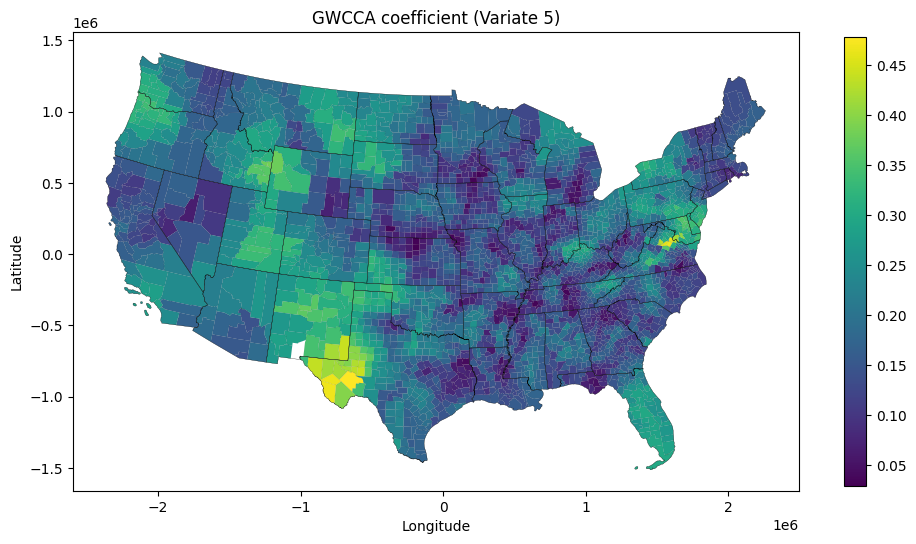

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_gwcca_result(data, rho, title="GWCCA coefficient", component_idx=5, ax=ax)

state_boundary.boundary.plot(ax=ax, color='#000000', linewidth=0.2)

plt.tight_layout()
plt.show()
plt.savefig("/content/drive/My Drive/GCCA/rho5.png", dpi=600)

In [ ]:
import pandas as pd

coefficients_stats = pd.DataFrame(rho)
coefficients_stats.describe()

,0,1,2,3,4
count,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000
mean,0.978235,0.891925,0.613129,0.330259,0.174198
std,0.007839,0.048276,0.126943,0.105908,0.073064
min,0.937401,0.730433,0.275068,0.083287,0.028984
25%,0.974828,0.862842,0.527282,0.251933,0.120776
50%,0.979484,0.904739,0.604585,0.316649,0.162622
75%,0.983532,0.926804,0.701182,0.387240,0.218206
max,0.991342,0.968518,0.941959,0.700713,0.478466


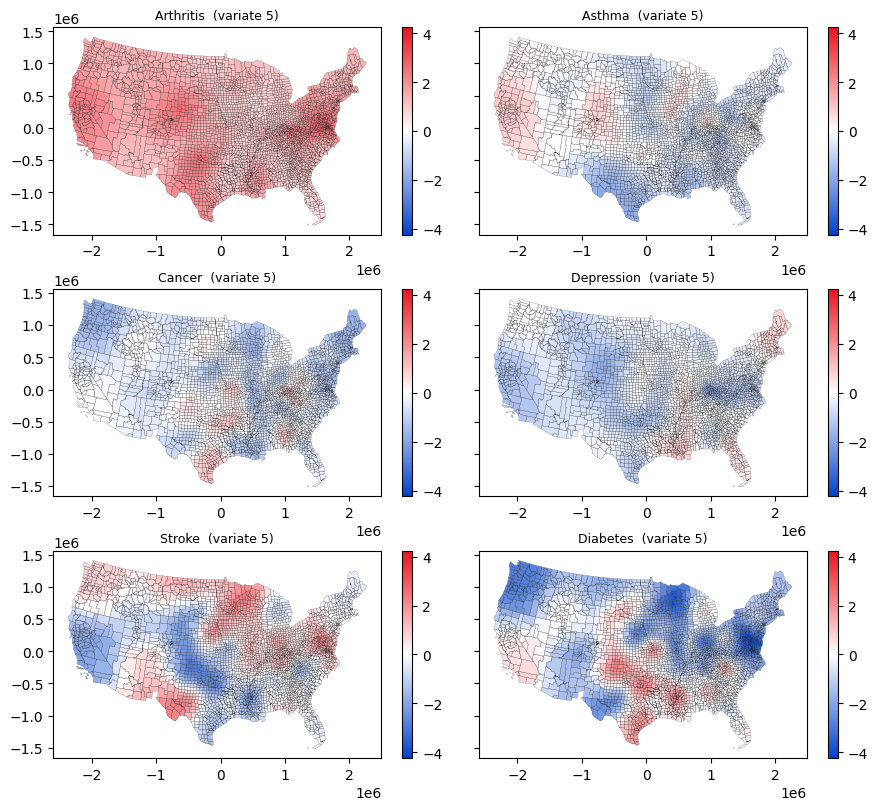

In [ ]:
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_diverging", ["#0042ca", "white", "#e9141e"], N=256
)

plot_loading_maps(data, a, X_names, component_idx=5, nrows=3, ncols=2, figsize=(9,8),cmap=cmap, diverging=True)
plt.savefig("/content/drive/My Drive/GCCA/a5.png", dpi=600)

In [ ]:
coefficients = a

stats = {
    'Min': np.min(coefficients[:, :, 0], axis=0),
    '25th Percentile': np.percentile(coefficients[:, :, 0], 25, axis=0),
    'Median (50th Percentile)': np.percentile(coefficients[:, :, 0], 50, axis=0),
    '75th Percentile': np.percentile(coefficients[:, :, 0], 75, axis=0),
    'Max': np.max(coefficients[:, :, 0], axis=0),
    'Mean': np.mean(coefficients[:, :, 0], axis=0),
    'abs-mean': np.mean(np.abs(coefficients[:, :, 0]), axis=0)
}

coefficients_stats = pd.DataFrame(stats, index=X_columns)
coefficients_stats["Component"] = "Component 1"

coefficients_stats

,Min,25th Percentile,Median (50th Percentile),75th Percentile,Max,Mean,abs-mean,Component
arth,0.041448,0.124338,0.225190,0.341028,0.519202,0.237065,0.237065,Component 1
asthma,-0.498685,-0.176913,-0.081472,-0.011379,0.070081,-0.109688,0.119231,Component 1
cancer,-0.070240,0.151268,0.237025,0.320918,0.517275,0.241476,0.242777,Component 1
deprss,-0.046096,0.037041,0.068100,0.107620,0.261975,0.074230,0.077368,Component 1
stroke,-0.998429,-0.687411,-0.578645,-0.445662,0.018605,-0.562096,0.562172,Component 1
diabet,-1.305151,-0.614453,-0.479594,-0.394575,-0.113396,-0.533739,0.533739,Component 1


In [ ]:
coefficients = a

stats = {
    'Min': np.min(coefficients[:, :, 1], axis=0),
    '25th Percentile': np.percentile(coefficients[:, :, 1], 25, axis=0),
    'Median (50th Percentile)': np.percentile(coefficients[:, :, 1], 50, axis=0),
    '75th Percentile': np.percentile(coefficients[:, :, 1], 75, axis=0),
    'Max': np.max(coefficients[:, :, 1], axis=0),
    'Mean': np.mean(coefficients[:, :, 1], axis=0),
    'abs-mean': np.mean(np.abs(coefficients[:, :, 1]), axis=0)
}

coefficients_stats = pd.DataFrame(stats, index=X_columns)
coefficients_stats["Component"] = "Component 2"

coefficients_stats

,Min,25th Percentile,Median (50th Percentile),75th Percentile,Max,Mean,abs-mean,Component
arth,0.123613,0.327051,0.457626,0.645012,1.459371,0.535627,0.535627,Component 2
asthma,-0.791960,-0.086993,0.075792,0.233396,0.546828,0.062368,0.198444,Component 2
cancer,-0.508737,0.398965,0.737080,0.966663,1.589795,0.682904,0.704927,Component 2
deprss,-0.777563,-0.049986,0.103236,0.250928,0.552532,0.078863,0.206193,Component 2
stroke,-0.905109,0.550433,0.826296,1.181334,2.492421,0.857887,0.896320,Component 2
diabet,-2.502003,-0.868361,-0.600116,-0.316169,0.458612,-0.648466,0.662447,Component 2


In [ ]:
coefficients = a

stats = {
    'Min': np.min(coefficients[:, :, 1], axis=0),
    '25th Percentile': np.percentile(coefficients[:, :, 1], 25, axis=0),
    'Median (50th Percentile)': np.percentile(coefficients[:, :, 1], 50, axis=0),
    '75th Percentile': np.percentile(coefficients[:, :, 1], 75, axis=0),
    'Max': np.max(coefficients[:, :, 1], axis=0),
    'Mean': np.mean(coefficients[:, :, 1], axis=0),
    'abs-mean': np.mean(np.abs(coefficients[:, :, 1]), axis=0)
}

coefficients_stats = pd.DataFrame(stats, index=X_columns)
coefficients_stats["Component"] = "Component 3"

coefficients_stats

,Min,25th Percentile,Median (50th Percentile),75th Percentile,Max,Mean,abs-mean,Component
arth,0.123613,0.327051,0.457626,0.645012,1.459371,0.535627,0.535627,Component 3
asthma,-0.791960,-0.086993,0.075792,0.233396,0.546828,0.062368,0.198444,Component 3
cancer,-0.508737,0.398965,0.737080,0.966663,1.589795,0.682904,0.704927,Component 3
deprss,-0.777563,-0.049986,0.103236,0.250928,0.552532,0.078863,0.206193,Component 3
stroke,-0.905109,0.550433,0.826296,1.181334,2.492421,0.857887,0.896320,Component 3
diabet,-2.502003,-0.868361,-0.600116,-0.316169,0.458612,-0.648466,0.662447,Component 3


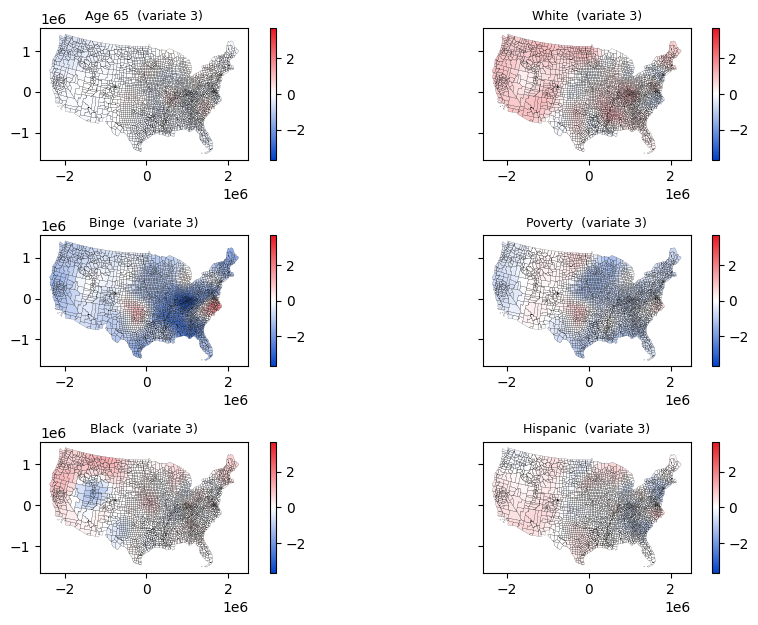

In [ ]:
plot_loading_maps(data, b, Y_names, component_idx=3, nrows=4, ncols=2, figsize=(9,8),cmap=cmap, diverging=True)
plt.savefig("/content/drive/My Drive/GCCA/b4.png", dpi=600)

In [ ]:
coefficients = b

stats = {
    'Min': np.min(coefficients[:, :, 0], axis=0),
    '25th Percentile': np.percentile(coefficients[:, :, 0], 25, axis=0),
    'Median (50th Percentile)': np.percentile(coefficients[:, :, 0], 50, axis=0),
    '75th Percentile': np.percentile(coefficients[:, :, 0], 75, axis=0),
    'Max': np.max(coefficients[:, :, 0], axis=0),
    'Mean': np.mean(coefficients[:, :, 0], axis=0),
    'abs-mean': np.mean(np.abs(coefficients[:, :, 0]), axis=0)
}

coefficients_stats = pd.DataFrame(stats, index=Y_columns)
coefficients_stats["Component"] = "Component 1"

coefficients_stats

In [ ]:
coefficients = b

stats = {
    'Min': np.min(coefficients[:, :, 0], axis=0),
    '25th Percentile': np.percentile(coefficients[:, :, 0], 25, axis=0),
    'Median (50th Percentile)': np.percentile(coefficients[:, :, 0], 50, axis=0),
    '75th Percentile': np.percentile(coefficients[:, :, 0], 75, axis=0),
    'Max': np.max(coefficients[:, :, 0], axis=0),
    'Mean': np.mean(coefficients[:, :, 0], axis=0),
    'abs-mean': np.mean(np.abs(coefficients[:, :, 0]), axis=0)
}

coefficients_stats = pd.DataFrame(stats, index=Y_columns)
coefficients_stats["Component"] = "Component 2"

coefficients_stats

In [ ]:
# Save results to geojson
data = data.to_crs(epsg=4326)
save_to_geo(data, rho, a_smoothed, b_smoothed, X_names, Y_names, filename="/content/drive/My Drive/GCCA/gwcca_results.geojson")